In [17]:
import gmsh
import meshio
import numpy
import pygmsh
import h5py
import matplotlib.pyplot as plt
import numpy as np
import subprocess

In [18]:
resolution = 0.01
LT = 10
LB = 10
W = 5

point0 = (0, 0, 0)
point1 = (LB, 0, 0)
point2 = (LT, W, 0)
point3 = (0, W, 0)
# c = (2.5, 2.5, 0)
centers = [
           (1, 1, 0),
           (3, 1, 0),
           (5, 1, 0),
           (7, 1, 0),
           (9, 1, 0),
           (2, 2.5, 0),
           (4, 2.5, 0),
           (6, 2.5, 0),
           (8, 2.5, 0),
           (1, 4.10, 0),
           (3, 4.10, 0),
           (5, 4.10, 0),
           (7, 4.10, 0),
           (9, 4.10, 0),

]
r = 0.85

In [19]:
geometry = pygmsh.geo.Geometry()
model = geometry.__enter__()

In [20]:
points = [model.add_point(point0, mesh_size=resolution),
          model.add_point(point1, mesh_size=resolution),
          model.add_point(point2, mesh_size=resolution),
          model.add_point(point3, mesh_size=resolution),
          ]

In [21]:
channel_lines = [model.add_line(points[i], points[i+1])
  for i in range(-1, len(points)-1)]
channel_loop = model.add_curve_loop(channel_lines)
circles = [model.add_circle(c, r, mesh_size=resolution) for c in centers]
holes = [circle.curve_loop for circle in circles]
plane_surface = model.add_plane_surface(channel_loop, holes=holes)
model.synchronize()

In [22]:
volume_marker = 6
model.add_physical([plane_surface], "Volume")
model.add_physical([channel_lines[0]], "Left")
model.add_physical([channel_lines[2]], "Right")
model.add_physical([channel_lines[1], channel_lines[3]], "Insulated")
for i, c in enumerate(circles):
    model.add_physical(c.curve_loop.curves, "void%d" % i)

In [23]:
geometry.generate_mesh(dim=2)
gmsh.write("mesh.msh")
gmsh.clear()
geometry.__exit__()

In [24]:
mesh_from_file = meshio.read("mesh.msh")

In [25]:
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    return out_mesh

In [26]:
line_mesh = create_mesh(mesh_from_file, "line", prune_z=True)
meshio.write("facet_mesh.xdmf", line_mesh)

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write("mesh.xdmf", triangle_mesh)


In [27]:
subprocess.Popen(["mpirun", "-n", "2", "python3 demo_poisson.py"])

In [33]:
# load simulation results
with h5py.File("poisson.h5", 'r') as hf:
    values = np.asarray(hf.get("Function").get("f_4").get("0"))
    positions = np.asarray(hf.get("Mesh").get("Grid").get("geometry"))

results = np.hstack((positions, values))

In [34]:
idx = np.lexsort((results[:, 0], results[:, 1]))
results = results[idx]

In [42]:
[results[1001:5, :],
results[219500:, :],
219504/3]

[array([[0.        , 0.        , 1.        ],
        [0.01      , 0.        , 0.9995271 ],
        [0.02      , 0.        , 0.99905396],
        [0.03      , 0.        , 0.99858037],
        [0.04      , 0.        , 0.99810604]]),
 array([[9.97000000e+00, 5.00000000e+00, 7.74849362e-04],
        [9.98000000e+00, 5.00000000e+00, 5.16255027e-04],
        [9.99000000e+00, 5.00000000e+00, 2.58034505e-04],
        [1.00000000e+01, 5.00000000e+00, 0.00000000e+00]]),
 73168.0]

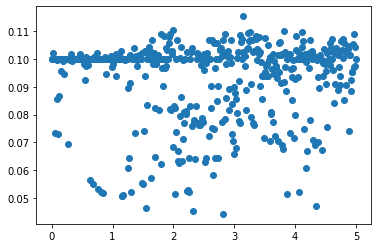

[0.20554983895326248, 0.216]

In [68]:
x_series = np.arange(0, 10.01, 0.01)
y_series = np.arange(0, 5.01, 0.01)

grad_data = np.zeros(results.shape)
avg_cond = []
for y_val in y_series:
    results_slice = results[np.where(np.isclose(results[:, 1], y_val))]
    x_vals = results_slice[:, 0]
    u_vals = results_slice[:, 2]
    grad = -np.divide(u_vals[1:] - u_vals[:-1], x_vals[1:] - x_vals[:-1])
    avg_cond.append(np.average(grad))
plt.scatter(y_series, avg_cond)
plt.show()
["model: ", np.average(avg_cond), "bruggeman: ", 0.36**1.5]